In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython
%reload_ext Cython

In [2]:
import sys
sys.path.append('../..')
sys.path.append('..')

import warnings
def warn(message, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.style.use('seaborn-paper')
from lifelines import KaplanMeierFitter
from diabetes_onset import survival_diabetes

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import lifelines
from lifelines import CoxPHFitter 
from lifelines import WeibullFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts, rmst_plot
from lifelines.utils import restricted_mean_survival_time



from diabetes_onset_plotter import survival_fit_res, make_results
import scipy.stats as sts
from utils import statistics_first_month,p_val, stat_matrices

In [3]:
#mpl.style.use('seaborn-paper')
font = {'family':'Times New Roman',
        'weight': 'normal',
        'size': 16
        }

axes_font = {'labelsize':20}
mpl.rc('font', **font)
mpl.rc('axes', **axes_font)

In [4]:
#pd.set_option('max_columns', None)
#pd.set_option('max_rows', None)


In [5]:
np.random.seed(seed = 0)

In [6]:

def diff(treated, controls, controls3, pmpm,
         group_name = "",
         check = False, month = 5,
         pf = "", pt = "",  pf2 = ""):
    tr = treated.copy()
    cr = controls.copy()
    controls3 = controls3.copy()
    treated2 = (filter_first_date(findDate(tr.copy(), pmpm.copy(), month), check = False)).sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
    controls2 = (filter_first_date(findDate(cr.copy(), controls3.copy(), month), check  = False)).sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
    try:
        controls2.MBR_GNDR.replace(to_replace = {'F':0, 'M':1}, inplace = True)
    except:
        controls2 = controls2
    treated2.MBR_GNDR.replace(to_replace = {'F':0, 'M':1}, inplace = True)
    treated2['Treatment'] = 1
    controls2['Treatment'] = 0
    #data2 = [treated2,  controls2]
    #for d in data2:
    #    d['Acute-bin'] = ((d['ALLOW_ER'] > 0) | (d['ALLOW_IP'] > 0)).astype(int)
    print(treated2.shape, controls2.shape)
    print(treated.PERS_ID.unique().shape, controls.PERS_ID.unique().shape)
    print(treated2.PERS_ID.unique().shape, controls2.PERS_ID.unique().shape)
    print(treated2.columns)
    ### see the stats after the drop
    all_columns = list(set(col for col in pmpm.columns)-set(['PERS_ID', 'MYR','MEDICAID_LOB']))
    columns_to_match =  ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY', 
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID',
                         'CC_DX_CNT', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6','LOB',
                        'Acute6-bin']
    
    all_columns = all_columns +['Acute6-bin']
    
    
    treated2['Acute6-bin'] = (treated2['ACUTE6'] > 0).astype(int)
    controls2['Acute6-bin'] = (controls2['ACUTE6'] > 0).astype(int)

    tr_desc1, treated_first_month = statistics_first_month(treated2.copy(), all_columns, return_array = True, month = month)
    con_desc1, controls_first_month = statistics_first_month(controls2.copy(), all_columns, return_array = True,  month = month)
    conds_first, full_first = stat_matrices(tr_desc1, con_desc1, tr_desc1, con_desc1, columns = columns_to_match)
    conds_firstAllCols, full_firstAllCols = stat_matrices(tr_desc1, con_desc1, tr_desc1, con_desc1, columns = all_columns)
    
    times = [0]
    onset = 'ACUTE'
    survTr = treated2.copy().groupby('PERS_ID').apply(survival_diabetes,  grace = times[0], onset = onset).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])
    survCo = controls2.copy().groupby('PERS_ID').apply(survival_diabetes, grace = times[0], onset = onset).reset_index(drop = True)#.dropna(axis = 0, subset = ['PERS_ID'])
    
    fittedDD, rmstAcuteDD = survival_fit_res( ['Treated', 'Controls'],  survTr.copy(), survCo.copy(),
                      model = model, model_type = model_type,
                      model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                     log_normalize = log_normalize, normalize = normalize)

    outcome = 'Acute-Care_dd_'+str(group_name)
    #global path_figs, path_figs2, path_tabs
    ylim = [0.7]
    path_figsA = path_figs+pf
    path_figs2A = path_figs2+pf
    path_tabsA = path_tabs+pf
    Path(path_figsA).mkdir(parents = True, exist_ok = True)
    Path(path_figs2A).mkdir(parents = True, exist_ok = True)
    Path(path_tabsA).mkdir(parents = True, exist_ok = True)



    lrsummDD, ax1, ax2, summDD = make_results(fittedDD, survTr.copy(), survCo.copy(), path_tabs = path_tabsA, 
                                      path_figs=path_figsA,  path_figs2=path_figs2A,  surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                      timeline = timeline,
                                      outcome_title = 0, ylim = ylim, ver_line = True, ver_line_val = 6)
    
    statsFM = [conds_first, full_first, conds_firstAllCols, full_firstAllCols]
    return rmstAcuteDD, lrsummDD, statsFM, [survTr, survCo]
    # curves.append((survTr, survCo))

In [7]:
%%time
clusters = 2
sec_id = ""
p = '../tempNNhierAgglo/'
#p1 = 'tempNNhierAgglo2Clust/'
p1 = 'tempNNhierAgglotheory{}Clusters{}/'.format(clusters, sec_id)
p2 = 'whole_pop/effects/'
base_path = '../results/'+p2


CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.06 µs


### Optional(filter registrations after  a particular month and before a particular month)

In [8]:
def setfirst(group):
    group['First'] = group.MYR.iloc[0]
    return group

FILTER = False
if FILTER:
    treated = treated.groupby('PERS_ID').apply(lambda x: setfirst(x)).reset_index(drop = True)
    controls = controls.groupby('PERS_ID').apply(lambda x: setfirst(x)).reset_index(drop = True)

    month_filter_lower = 202001
    month_filter_upper = 202101
    myr_filt = (treated.First <= month_filter_upper) & (treated.First >= month_filter_lower)
    treated = treated[myr_filt].reset_index(drop = True)

    myr_filt = (controls.First <= month_filter_upper) & (controls.First >= month_filter_lower)
    controls = controls[myr_filt].reset_index(drop = True)


### Set common variables

In [9]:
filter_cols =  ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY', 
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6','LOB', 'T', 'E','TxG0','TxG1']

log_normalize = ['ALLOW_AMT']
normalize = ['AGE_AT_MIDMONTH', 'CC_DX_CNT']
#normalize = ['AGE_AT_MIDMONTH', 'ALLOW_AMT']

model_type = 'kaplan'
model = KaplanMeierFitter
model_argsK = {}#{'timeline':24}# {"penalizer":0.001, 'alpha': 0.05}
model_args={}#{"penalizer":0.001, 'alpha': 0.05}# {}
fit_args = {"step_size": 0.01, "show_progress":True}

timeline = 24
fit_args1 = {"timeline":np.arange(timeline)}
#put title in the figures 1 0 no
outcome_title = 0

kaplan_plot_params = {"show_censors": False, "ci_alpha":0.1, "ci_force_lines":False}# "at_risk_counts": False}

In [10]:

path_tabs = base_path+'tables/survival/'
path_figs = base_path+'figures/kaplan/'
path_figs2 = base_path+'figures/cox/' #plots without risk at count

#create paths if not created
from pathlib import Path
p1 = Path(path_tabs)
p2 = Path(path_figs)
p3 = Path(path_figs2)

p1.mkdir(parents = True, exist_ok = True)
p2.mkdir(parents = True, exist_ok = True)
p3.mkdir(parents = True, exist_ok = True)

In [11]:
filter_cols2 =  ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY', 
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6','LOB', 'T', 'E', 'Treatment','TxG0','TxG1']

summary_names = ['Age', 'Total Cost', 'Gender', 'Tobacco Use', 'Pressure', 'Obesity', 
                'Hypertension', 'Hypothyroid', 'Disease Count','Acute Care 2 Months', 'Acute Care 6 Months',
                'Inpatient Visits 6 Months', 'Emergency Vistits 6 Months', 'Line of Bussiness', 'Treatment', 'TxG0','TxG1']

In [12]:
%%time
after = 0
grace = 0 # if grace is setted after is setted 0 by default


CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 9.54 µs


### Acute Care  diff and diff calculation

In [13]:
%%time
from utils import findDate, filter_first_date
from data_functions import make_date_to_MYR

pmpm2 = pd.read_pickle('../Pre_Matching_DATA/'+'pmpm.p').sort_values(by = 
                                                                    ['PERS_ID', 'MYR']).reset_index(drop = True)

controls2 = pd.read_pickle('../Pre_Matching_DATA/'+'controls_all.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

CPU times: user 11.7 s, sys: 12.6 s, total: 24.3 s
Wall time: 24.3 s


In [14]:
import pickle
p3 = '../tempNNhierAgglotheory{}Clusters{}/'.format(clusters, sec_id)
sv1 = p3+'cg{}{}.p'.format(clusters, sec_id)
sv2 = p3+'tg{}{}.p'.format(clusters, sec_id)

with open(sv1, 'rb') as handle:
    control_groups = pickle.load(handle)

with open(sv2, 'rb') as handle:
    treated_groups = pickle.load(handle)

In [15]:
control_groups[0]['TxG0'] = 0
control_groups[0]['TxG1'] = 0
control_groups[1]['TxG0'] = 0
control_groups[1]['TxG1'] = 0

treated_groups[0]['TxG0'] = 1
treated_groups[0]['TxG1'] = 0
treated_groups[1]['TxG0'] = 0
treated_groups[1]['TxG1'] = 1

In [16]:
controls = pd.concat((control_groups[0],control_groups[1]),ignore_index = True)
treated = pd.concat((treated_groups[0],treated_groups[1]),ignore_index = True)

treated.reset_index(drop = True, inplace = True)
controls.reset_index(drop = True, inplace = True)

In [18]:
controls22 = controls2.copy().merge(controls[['PERS_ID','MYR','TxG0','TxG1']], how = 'left', on = ['PERS_ID','MYR'])
pmpm = pmpm2.copy().merge(treated[['PERS_ID','MYR','TxG0','TxG1']], how = 'left',on = ['PERS_ID','MYR'])

In [19]:
pmpm.shape, controls22.shape

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


(22323, 102) (104240, 105)
(1364,) (6820,)
(1364,) (6820,)
Index(['PERS_ID', 'MYR', 'MBR_GNDR', 'AGE_AT_MIDMONTH', 'ALLOW_AMT',
       'MEDICAID_LOB', 'ALLOW_ER', 'ALLOW_IP', 'CC_ADHD', 'CC_ALZHEIMER',
       ...
       'TxG1', 'REG_DATE', 'PAST_DATE', 'PAST_DATE00', 'PAST_DATE0',
       'PAST_DATE1', 'PAST_DATE2', 'PAST_DATE3', 'IN_STUDY', 'Treatment'],
      dtype='object', length=102)


ConvergenceError: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.

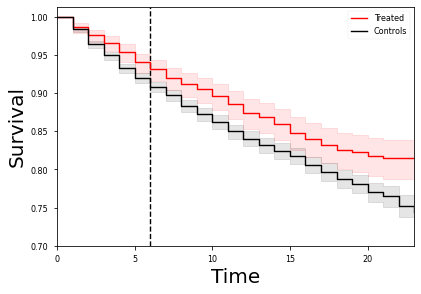

In [21]:
_,_,_,_ = diff(treated, controls, controls22, pmpm,month = 0)